# Downsampling data to perform aggregate predictions

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
from script import *

### Load data

In [3]:
DATA_PATH = '../data/405.txt'

cols_map = {
    "DTS": "crossTime",
    #"LANE": "lane",
    #"DIR": "direction",
    "SPEED": "speed",
    # "AX": "nAxles",
    "GW_TOT": "weight",
    # "TYPE": "type",
}

data = pd.read_csv(DATA_PATH, usecols=cols_map.keys())
data.rename(columns=cols_map, inplace=True)
# Parse crossTime column as datetime object
data.crossTime = pd.to_datetime(data.crossTime+'0000', format="%Y-%m-%d %H:%M:%S.%f")
data.head(2)

,crossTime,speed,weight
0,2011-04-01 00:41:31.400,106,15980
1,2011-04-01 00:42:10.500,116,3630


In [4]:
feature_cols = [col for col in data.columns if col != 'crossTime']
features = data[feature_cols]
features.index = data.crossTime
# Downsample
features = features.resample('1h').sum()
features.head(5)

,speed,weight
crossTime,,
2011-04-01 00:00:00,306,38090
2011-04-01 01:00:00,540,107870
2011-04-01 02:00:00,258,69670
2011-04-01 03:00:00,350,43060
2011-04-01 04:00:00,1211,290270


### Feature engineering

#### is_legal feature

In [5]:
# TODO

#### Time periodicity features
Datetime column `crossTime` not useful in its string form. We extract time of day, time of the week, and/or time of the year information to analyse periodicity. In order to deal with periodicity, we use sine and cosine transforms to get usable signals.

In [6]:
# Transform to seconds
timestamp_s = features.index.map(pd.Timestamp.timestamp)

# Corresponding length in seconds for day, week, year
minute_s = 60
hour_s = minute_s * 60
day_s = 24 * hour_s # 24h x 60m x 60s
week_s = 7 * day_s
year_s = 365.2425 * day_s

In [7]:
# Add sin/cos periodicity columns to features dataframe
def add_time_period_cols(time_length, time_string):
    features[time_string + '_sin'] = np.sin(timestamp_s * (2 * np.pi / time_length))
    features[time_string + '_cos'] = np.cos(timestamp_s * (2 * np.pi / time_length))
    
add_time_period_cols(day_s, 'day')
add_time_period_cols(week_s, 'week')
add_time_period_cols(year_s, 'year')

In [8]:
features.head(2)

,speed,weight,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos
crossTime,,,,,,,,
2011-04-01 00:00:00,306,38090,1.461574e-12,1.000000,0.781831,0.62349,0.999768,0.021556
2011-04-01 01:00:00,540,107870,2.588190e-01,0.965926,0.804598,0.59382,0.999783,0.020839


Text(0.5, 1.0, 'Year period signals')

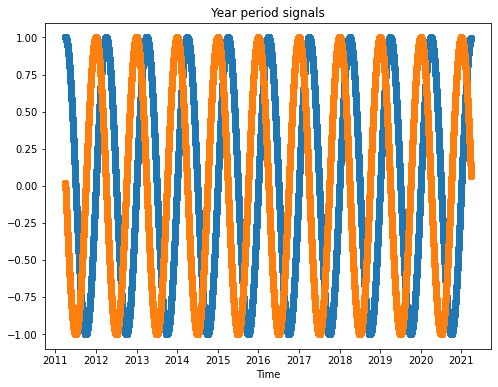

In [9]:
plt.scatter(y=np.array(features['year_sin']), x=features.index)
plt.scatter(y=np.array(features['year_cos']), x=features.index)
plt.xlabel('Time')
plt.title('Year period signals')

### Split and normalize data

In [10]:
train, val, test = split_norm_data(features)

### Predicting single feature (weight)


In [11]:
# Define window
day_window = WindowGenerator(input_width=24, label_width=1, shift=1, label_columns=['weight'],
                            train_df=train, val_df=val, test_df=test)
day_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['weight']

In [13]:
def example_window(window):
    return tf.stack([np.array(train[:window.total_window_size]),
                           np.array(train[1000:1000+window.total_window_size]),
                           np.array(train[2000:2000+window.total_window_size])])

In [14]:
ex_window = example_window(day_window)
ex_inputs, ex_labels = day_window.split_window(ex_window)

In [15]:
day_window.set_example(ex_inputs, ex_labels)

### Predicting all features